# Self-Training

### semi-supervised learning  
label이 있는 데이터와 label이 없는 데이터를 모두 활용하는 학습 방법
### self-training  
semi-supervised learning의 한 종류  
모델이 높으 확률로 예측하는 값은 정답일 것이라는 가정에 기반  
1. label이 있는 데이터로 모델을 학습시킴
2. label이 없는 데이터 중 일부를 모델에 넣어 예측값 생성
3. 생성된 예측값을 label로 간주하고 label이 있는 데이터에 추가하여 모델을 다시 학습시킴
4. 해당 과정을 반복

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')
import math
from xgboost import XGBClassifier

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

IRIS data, SVC

In [157]:
# 데이터 불러오기

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = [iris.target_names[x] for x in iris.target]
 
species_to_labels = dict(zip(df['species'].unique(), range(len(df['species'].unique()))))
df['species'] = df['species'].map(species_to_labels)
df = df.rename(columns={'species':'label'})
 
x = df.drop('label', axis=1).values
y = df['label'].values

In [158]:
# 원래 데이터에는 y값이 0,1,2 순서로 있음 - 골고루 학습하기 위해 행을 섞어줌

x = pd.DataFrame(x)
y = pd.DataFrame(y)
y.columns = ['y']
data = pd.concat([x, y], axis=1).sample(frac=1).reset_index(drop=True)

In [159]:
scorea = []
x_axisa = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 30%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

scorea.append(1)
x_axisa.append(45)

clf = SVC()
clf.fit(x_labeled, y_labeled)

# 나머지 데이터 중 일부를 모델로 예측해서 labeled 데이터에 추가해 모델 학습 반복

y_pred1 = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[45:90]))
y_pred1.columns = ['y']

x_labeled = data.drop(columns='y', axis=1)[:90]
y_labeled = pd.concat([y_labeled, y_pred1], axis=0)

scorea.append(accuracy_score(y[:90], y_labeled))
x_axisa.append(90)

clf = SVC()
clf.fit(x_labeled, y_labeled)

y_pred2 = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[90:135]))
y_pred2.columns = ['y']

x_labeled = data.drop(columns='y', axis=1)[:135]
y_labeled = pd.concat([y_labeled, y_pred2], axis=0)

scorea.append(accuracy_score(y[:135], y_labeled))
x_axisa.append(135)

clf = SVC()
clf.fit(x_labeled, y_labeled)

y_pred3 = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[135:]))
y_pred3.columns = ['y']

x_labeled = data.drop(columns='y', axis=1)
y_labeled = pd.concat([y_labeled, y_pred3], axis=0)

scorea.append(accuracy_score(y, y_labeled))
x_axisa.append(150)

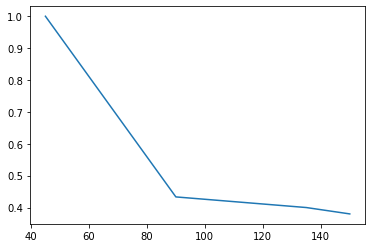

In [160]:
# 학습 과정에서의 성능 평가

plt.plot(x_axisa, scorea)

전체적으로 성과가 좋지 않다.  
전체 데이터의 30%씩 예측해서 사용했는데, 한 번에 너무 많은 양을 예측해서 사용한 것 같다.  
한 번에 예측하는 데이터의 양을 줄이고 학습 횟수를 늘려봐야겠다.

In [161]:
score_10a = []
x_axis_10a = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 10%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

score_10a.append(1)
x_axis_10a.append(45)

a = 45
b = int((150-45)/(150*0.1))

for i in range(1, b+1):
    clf = SVC()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:45+(15*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:45+(15*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_10a.append(accuracy_score(y[:45+(15*i)], y_labeled))
    x_axis_10a.append(45+(15*i))
    
    a = 45+15*i

In [162]:
score_5a = []
x_axis_5a = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 5%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

score_5a.append(1)
x_axis_5a.append(45)

a = 45
b = int((150-45)/math.floor(150*0.05))

for i in range(1, b+1):
    clf = SVC()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:45+(7*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:45+(7*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_5a.append(accuracy_score(y[:45+(7*i)], y_labeled))
    x_axis_5a.append(45+(7*i))
    
    a = 45+7*i

In [163]:
score_1a = []
x_axis_1a = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 1%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

score_1a.append(1)
x_axis_1a.append(45)

a = 45
b = int((150-45)/math.floor(150*0.01))

for i in range(1, b+1):
    clf = SVC()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:45+(1*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:45+(1*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_1a.append(accuracy_score(y[:45+(1*i)], y_labeled))
    x_axis_1a.append(45+(1*i))
    
    a = 45+1*i

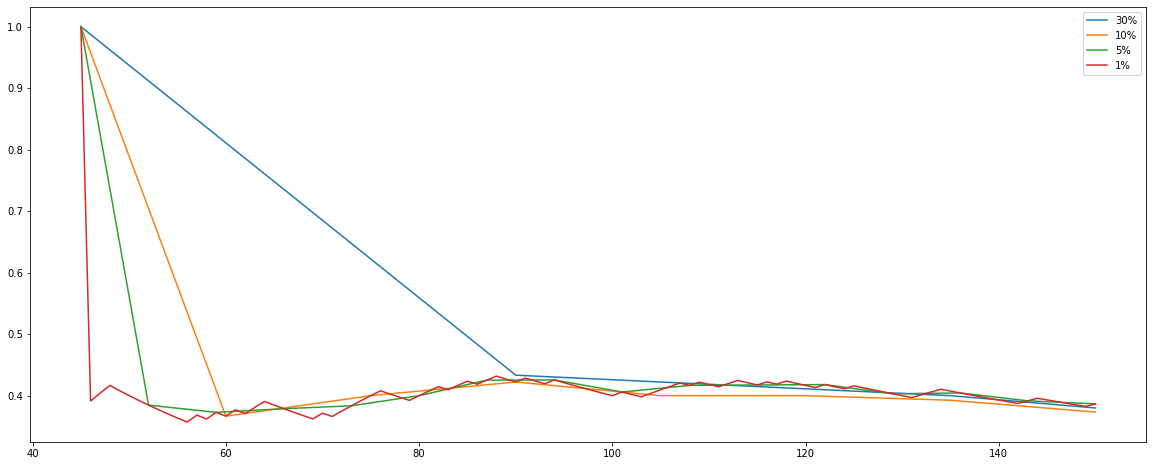

In [164]:
# 학습 과정에서의 성능 평가 비교

plt.figure(figsize=(20,8))
plt.plot(x_axisa, scorea, label='30%')
plt.plot(x_axis_10a, score_10a, label='10%')
plt.plot(x_axis_5a, score_5a, label='5%')
plt.plot(x_axis_1a, score_1a, label='1%')
plt.legend()

예측하는 데이터의 양을 줄이고 학습 횟수를 늘려보아도 성과는 크게 나아지지 않았다.  
다른 데이터에서도 실험을 진행해보겠다.

Wine data, SVC

In [174]:
# 데이터 불러오기

wine = load_wine()
x = pd.DataFrame(wine.data)
y = pd.DataFrame(wine.target)

# 원래 데이터에는 y값이 0,1,2 순서로 있음 - 골고루 학습하기 위해 행을 섞어줌

y.columns = ['y']
data = pd.concat([x, y], axis=1).sample(frac=1).reset_index(drop=True)

In [175]:
score = []
x_axis = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 30%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

score.append(1)
x_axis.append(53)

a = 53
b = int((178-53)/math.floor(178*0.3))

for i in range(1, b+1):
    clf = SVC()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(53*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(53*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score.append(accuracy_score(y[:53+(53*i)], y_labeled))
    x_axis.append(53+(53*i))
    
    a = 53+53*i

In [176]:
score_10 = []
x_axis_10 = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 10%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

score_10.append(1)
x_axis_10.append(53)

a = 53
b = int((178-53)/math.floor(178*0.1))

for i in range(1, b+1):
    clf = SVC()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(17*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(17*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_10.append(accuracy_score(y[:53+(17*i)], y_labeled))
    x_axis_10.append(53+(17*i))
    
    a = 53+17*i

In [177]:
score_5 = []
x_axis_5 = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 5%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

score_5.append(1)
x_axis_5.append(53)

a = 53
b = int((178-53)/math.floor(178*0.05))

for i in range(1, b+1):
    clf = SVC()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(8*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(8*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_5.append(accuracy_score(y[:53+(8*i)], y_labeled))
    x_axis_5.append(53+(8*i))
    
    a = 53+8*i

In [178]:
score_1 = []
x_axis_1 = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 1%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

score_1.append(1)
x_axis_1.append(53)

a = 53
b = int((178-53)/math.floor(178*0.01))

for i in range(1, b+1):
    clf = SVC()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(1*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(1*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_1.append(accuracy_score(y[:53+(1*i)], y_labeled))
    x_axis_1.append(53+(1*i))
    
    a = 53+1*i

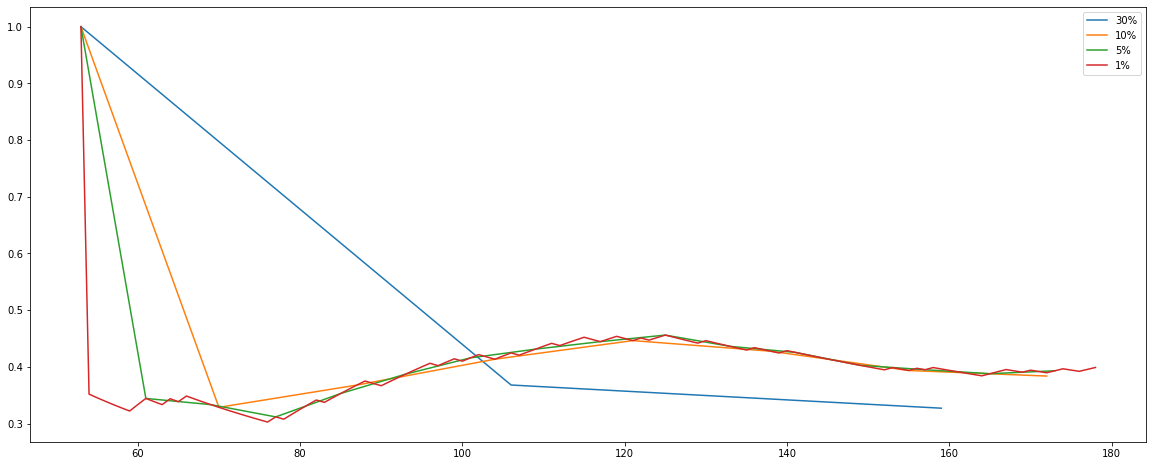

In [142]:
# 학습 과정에서의 성능 평가 비교

plt.figure(figsize=(20,8))
plt.plot(x_axis, score, label='30%')
plt.plot(x_axis_10, score_10, label='10%')
plt.plot(x_axis_5, score_5, label='5%')
plt.plot(x_axis_1, score_1, label='1%')
plt.legend()

30%씩 예측해서 사용하는 것보다는 더 적은 양의 데이터를 예측해서 사용하는 것이 더 성과가 좋았다.  
하지만 여전히 전체적으로 성과가 크게 차이는 없다.  
다른 모델에서도 비슷한 결과를 보일지 확인해보겠다.

IRIS data, XGBClassifier

In [144]:
# 데이터 불러오기

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = [iris.target_names[x] for x in iris.target]
 
species_to_labels = dict(zip(df['species'].unique(), range(len(df['species'].unique()))))
df['species'] = df['species'].map(species_to_labels)
df = df.rename(columns={'species':'label'})
 
x = df.drop('label', axis=1).values
y = df['label'].values

# 원래 데이터에는 y값이 0,1,2 순서로 있음 - 골고루 학습하기 위해 행을 섞어줌

x = pd.DataFrame(x)
y = pd.DataFrame(y)
y.columns = ['y']
data = pd.concat([x, y], axis=1).sample(frac=1).reset_index(drop=True)

In [150]:
score = []
x_axis = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 30%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

score.append(1)
x_axis.append(45)

a = 45
b = int((150-45)/math.floor(150*0.3))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:45+(45*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:45+(45*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score.append(accuracy_score(y[:45+(45*i)], y_labeled))
    x_axis.append(45+(45*i))
    
    a = 45+45*i

In [152]:
score_10 = []
x_axis_10 = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 10%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

score_10.append(1)
x_axis_10.append(45)

a = 45
b = int((150-45)/math.floor(150*0.1))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:45+(15*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:45+(15*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_10.append(accuracy_score(y[:45+(15*i)], y_labeled))
    x_axis_10.append(45+(15*i))
    
    a = 45+15*i

In [154]:
score_5 = []
x_axis_5 = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 5%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

score_5.append(1)
x_axis_5.append(45)

a = 45
b = int((150-45)/math.floor(150*0.05))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:45+(7*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:45+(7*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_5.append(accuracy_score(y[:45+(7*i)], y_labeled))
    x_axis_5.append(45+(7*i))
    
    a = 45+7*i

In [155]:
score_1 = []
x_axis_1 = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 1%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:45]
y_labeled = pd.DataFrame(data['y'][:45])

score_1.append(1)
x_axis_1.append(45)

a = 45
b = int((150-45)/math.floor(150*0.01))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:45+(1*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:45+(1*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_1.append(accuracy_score(y[:45+(1*i)], y_labeled))
    x_axis_1.append(45+(1*i))
    
    a = 45+1*i

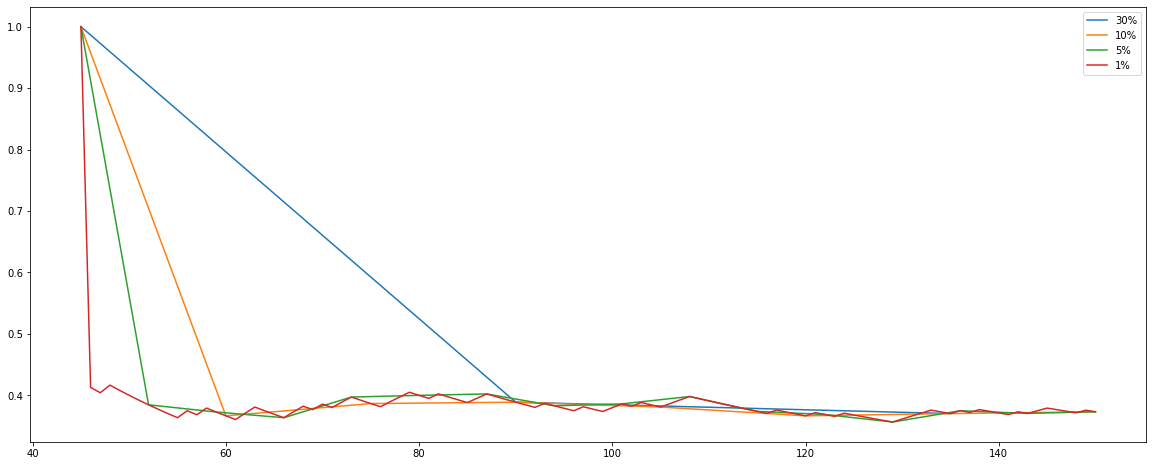

In [156]:
# 학습 과정에서의 성능 평가 비교

plt.figure(figsize=(20,8))
plt.plot(x_axis, score, label='30%')
plt.plot(x_axis_10, score_10, label='10%')
plt.plot(x_axis_5, score_5, label='5%')
plt.plot(x_axis_1, score_1, label='1%')
plt.legend()

SVC와 마찬가지로 XGBClassifier에서도 예측 데이터의 양을 줄인다고 해서 큰 성능 차이가 보이지 않았다.

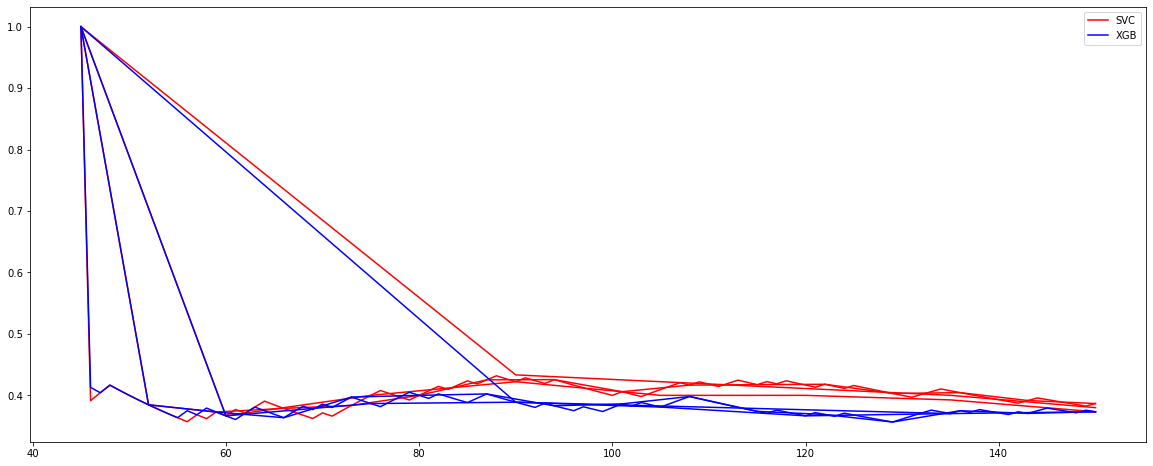

In [166]:
# 학습 과정에서의 성능 평가 비교

plt.figure(figsize=(20,8))
plt.plot(x_axisa, scorea, 'r', label='SVC')
plt.plot(x_axis_10a, score_10a, 'r')
plt.plot(x_axis_5a, score_5a, 'r')
plt.plot(x_axis_1a, score_1a, 'r')
plt.plot(x_axis, score, 'b', label='XGB')
plt.plot(x_axis_10, score_10, 'b')
plt.plot(x_axis_5, score_5, 'b')
plt.plot(x_axis_1, score_1, 'b')
plt.legend()

XGBClassifier보다는 SVC가 약간 더 좋은 성능을 보이지만, 큰 의미는 없는 것 같다

Wine data, XGBClassifier

In [167]:
# 데이터 불러오기

wine = load_wine()
x = pd.DataFrame(wine.data)
y = pd.DataFrame(wine.target)

# 원래 데이터에는 y값이 0,1,2 순서로 있음 - 골고루 학습하기 위해 행을 섞어줌

y.columns = ['y']
data = pd.concat([x, y], axis=1).sample(frac=1).reset_index(drop=True)

In [168]:
scoreb = []
x_axisb = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 30%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

scoreb.append(1)
x_axisb.append(53)

a = 53
b = int((178-53)/math.floor(178*0.3))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(53*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(53*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    scoreb.append(accuracy_score(y[:53+(53*i)], y_labeled))
    x_axisb.append(53+(53*i))
    
    a = 53+53*i

In [169]:
score_10b = []
x_axis_10b = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 10%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

score_10b.append(1)
x_axis_10b.append(53)

a = 53
b = int((178-53)/math.floor(178*0.1))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(17*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(17*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_10b.append(accuracy_score(y[:53+(17*i)], y_labeled))
    x_axis_10b.append(53+(17*i))
    
    a = 53+17*i

In [170]:
score_5b = []
x_axis_5b = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 5%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

score_5b.append(1)
x_axis_5b.append(53)

a = 53
b = int((178-53)/math.floor(178*0.05))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(8*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(8*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_5b.append(accuracy_score(y[:53+(8*i)], y_labeled))
    x_axis_5b.append(53+(8*i))
    
    a = 53+8*i

In [171]:
score_1b = []
x_axis_1b = []

# 일부 데이터만 label 사용해 학습시킴 (전체 데이터의 30%의 label 사용, 이후 1%씩 예측)

x_labeled = data.drop(columns='y', axis=1)[:53]
y_labeled = pd.DataFrame(data['y'][:53])

score_1b.append(1)
x_axis_1b.append(53)

a = 53
b = int((178-53)/math.floor(178*0.01))

for i in range(1, b+1):
    clf = XGBClassifier()
    clf.fit(x_labeled, y_labeled)
    
    y_pred = pd.DataFrame(clf.predict(data.drop(columns='y', axis=1)[a:53+(1*i)]))
    y_pred.columns = ['y']

    x_labeled = data.drop(columns='y', axis=1)[:53+(1*i)]
    y_labeled = pd.concat([y_labeled, y_pred], axis=0)

    score_1b.append(accuracy_score(y[:53+(1*i)], y_labeled))
    x_axis_1b.append(53+(1*i))
    
    a = 53+1*i

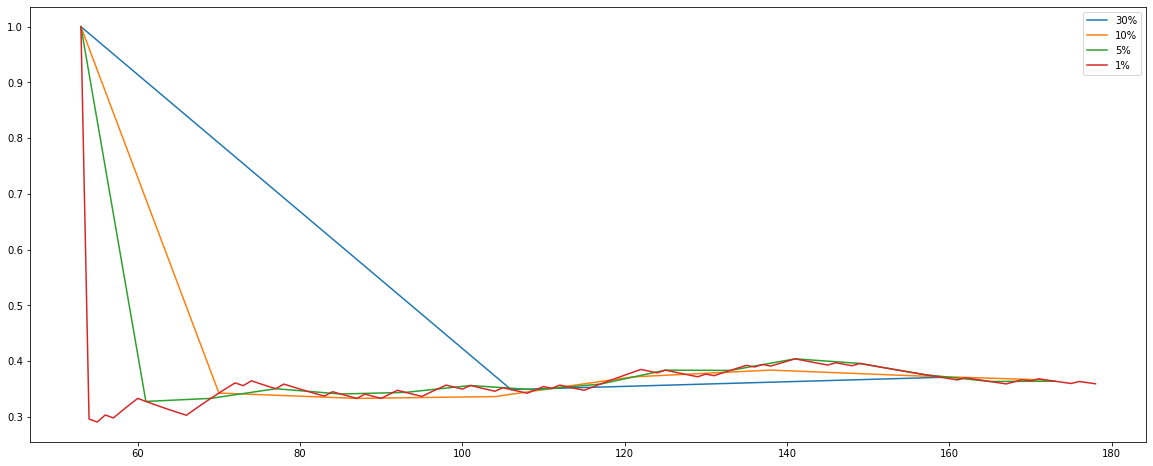

In [172]:
# 학습 과정에서의 성능 평가 비교

plt.figure(figsize=(20,8))
plt.plot(x_axisb, scoreb, label='30%')
plt.plot(x_axis_10b, score_10b, label='10%')
plt.plot(x_axis_5b, score_5b, label='5%')
plt.plot(x_axis_1b, score_1b, label='1%')
plt.legend()

Wine data에서도 역시 SVC와 비슷하게 XGBClassifier에서도 예측 데이터의 양을 줄인다고 해서 큰 성능 차이가 보이지 않았다.

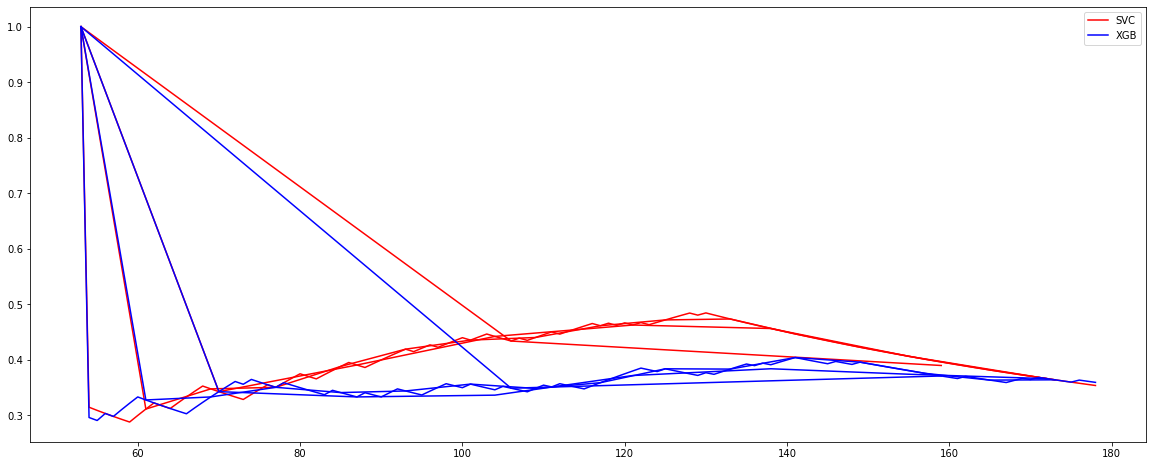

In [180]:
# 학습 과정에서의 성능 평가 비교

plt.figure(figsize=(20,8))
plt.plot(x_axis, score, 'r', label='SVC')
plt.plot(x_axis_10, score_10, 'r')
plt.plot(x_axis_5, score_5, 'r')
plt.plot(x_axis_1, score_1, 'r')
plt.plot(x_axisb, scoreb, 'b', label='XGB')
plt.plot(x_axis_10b, score_10b, 'b')
plt.plot(x_axis_5b, score_5b, 'b')
plt.plot(x_axis_1b, score_1b, 'b')
plt.legend()

Wine data에서도 역시 XGBClassifier보다는 SVC가 약간 더 좋은 성능을 보인다.

이번 튜토리얼에서는 semi-supervised learning의 한 종류인 self-training을 구현 및 실험해보았다.  
해당 방법론은 예측 데이터의 양에 크게 영향을 받지 않으며, 전체적으로 성능이 그렇게 뛰어나지는 않았다.  
하지만 사용하는 모델의 종류에 따라 약간의 성과 차이가 존재하기 때문에 적절한 모델을 찾아 사용해볼 수 있을 것 같다.